In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
data = pd.read_csv("S05-hw-dataset.csv")
data.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


# Разведочный анализ

In [32]:
data.info() # Пропущенных значений не обнаружено

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [33]:
data.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [34]:
data = data.drop_duplicates() # Дубликатов в исходных данных не было
data.shape

(3000, 17)

In [35]:
data['default'].value_counts(normalize=True) # Присутствует некоторый дисбаланс классов

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

In [36]:
len(data['client_id'].unique()) # Нет повторов id

3000

In [37]:
data = data.drop('client_id', axis=1) # уникальный идентификатор не влияет на результат работы
data.head()

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [38]:
# Ряд подозрительных случаев - человек начал работать ещё до достижения 14 лет. В ряде случаев это возможно, но не является столь распространённым, как представлено в данных (805 случаев, в части из которых человек начал работать до рождения)
data[data['age'] - data['years_employed'] < 14]

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
6,25,37840,25,691,0.032334,1,12,0,0,56999,973,0.432156,12,2,1,0
8,30,34321,36,687,0.620856,0,7,1,1,20995,3650,0.632998,17,1,1,1
9,25,25809,23,601,0.254544,5,0,0,1,38464,3379,0.367238,10,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,43,91196,33,740,0.124947,4,4,0,0,14830,8765,0.513254,5,0,11,0
2989,41,70168,35,541,0.265943,6,2,0,1,20626,-142,0.227945,1,0,13,0
2992,30,36394,35,724,0.277715,4,10,1,0,40323,5394,0.251583,8,2,11,1
2996,35,54454,36,634,0.396180,5,5,0,0,0,10858,0.506146,2,2,12,0


In [39]:
data = data[data['age'] - data['years_employed'] >= 14]
data

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1
5,63,71006,1,712,0.541594,3,0,0,0,14162,372,0.100423,12,0,13,0
7,55,35993,22,662,0.631521,0,0,0,1,5267,462,0.096401,6,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,62,80153,16,638,0.126050,4,2,0,1,6368,11673,0.620500,17,2,5,0
2994,58,84746,11,689,0.184119,4,11,1,0,15155,4530,0.193611,16,1,8,0
2995,51,131729,6,687,0.283093,3,1,1,0,13136,14209,0.251680,19,3,2,0
2997,38,63305,16,573,0.577888,2,13,0,1,24870,6689,0.366375,16,2,10,1


In [40]:
# Аналогично проанализируем число лет, которое человек обсуживается в банке. По закону, человек может иметь свою карту с 6 лет (привязанную к счёту родителя),
# поэтому нас будут интересовать случаи, где человек обслуживается в банке с 5 лет

data[data['age'] - data['customer_tenure_years'] < 6] # Таких нет

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default


Просрочек не может быть у человека, который не брал никаких кредитов. Однако, в данных присутствует только информация об активных займах и кредитах, в то время как число просрочек дано за некоторый период времени. Поэтому мы не можем исключить клиентов без займов / кредитов, но с наличием просрочки.

Но заметим, что в описании данных, полученном методом describe отношение ежемесячных долговых платежей к доходу никогда не равно нулю. Значит у каждого человека в данных есть долговая нагрузка.

In [41]:
data[(data['active_loans'] == 0) & (data['has_car_loan'] == 0) & (data['has_mortgage'] ==0) & (data['num_credit_cards'] ==0)] # У всех этих клиентов по данным нет обязательств, но есть ненулевое отношение долговых платежей к доходу

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
164,41,74810,7,704,0.284040,0,2,0,0,36420,-220,0.727007,9,0,8,0
301,61,50559,7,703,0.093125,0,10,0,0,0,751,0.142772,12,0,0,0
440,68,56135,38,631,0.138875,0,8,0,0,16330,5664,0.702956,11,0,8,0
528,65,49842,31,706,0.237064,0,10,0,0,30990,2895,0.436582,1,0,3,0
1133,58,87824,7,523,0.270864,0,5,0,0,33048,109,0.601662,19,0,14,0
1142,66,67804,21,760,0.207948,0,7,0,0,23475,1322,0.238798,18,0,5,0
1148,54,90679,13,665,0.268027,0,3,0,0,17844,1581,0.307627,6,0,0,0
1289,51,88744,2,571,0.277430,0,3,0,0,12932,942,0.744780,12,0,3,1
1308,41,90642,2,626,0.420049,0,1,0,0,16670,7998,0.144169,3,0,2,0
1336,52,84008,13,747,0.424628,0,3,0,0,0,2425,0.413764,14,0,8,0


In [42]:
data=data.drop(
    [164, 301, 440, 528, 1133, 1142, 1148, 1289, 1308, 1336, 1484]
)

# Разбиение данных

In [43]:
x_train, x_test, y_train,  y_test = train_test_split(
   data.drop('default', axis=1),
   data['default'],
   test_size=0.2,
   stratify=data['default'],
   random_state=42
)

# Baseline модель

In [44]:
baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GridSearchCV(
        DummyClassifier(random_state=42, constant=1),
        {'strategy': ['prior', 'stratified', 'uniform', 'constant']}
    ))
])

In [45]:
baseline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GridSearchCV(estimator=DummyClassifier(constant=1,
                                                        random_state=42),
                              param_grid={'strategy': ['prior', 'stratified',
                                                       'uniform',
                                                       'constant']}))])

In [46]:
baseline['model'].best_params_ # Лучшая стратегия - всегда классифицировать данные как принадлежащие самому распространённому (нулевому) классу

{'strategy': 'prior'}

In [47]:
y_pred = baseline.predict(x_test)
y_pred_probs = baseline.predict_proba(x_test)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       256
           1       0.00      0.00      0.00       181

    accuracy                           0.59       437
   macro avg       0.29      0.50      0.37       437
weighted avg       0.34      0.59      0.43       437



J:\CISM\Projects\bb\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
J:\CISM\Projects\bb\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
J:\CISM\Projects\bb\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
roc_auc_score(y_test, y_pred_probs[:,1])

0.5

Полученная модель абсолютно бесполезна, она причисляет все объекты к одному классу, а её предсказательная способность сравнима со случайным угадыванием

# Логистическая регрессия

In [50]:
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        {'C': [0.000001, 0.1, 1, 10, 100, 1000, 10000]}
    ))
])

In [51]:
logreg.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           random_state=42),
                              param_grid={'C': [1e-06, 0.1, 1, 10, 100, 1000,
                                                10000]}))])

In [52]:
logreg['model'].best_params_

{'C': 1}

In [53]:
y_pred = logreg.predict(x_test)
y_pred_probs = logreg.predict_proba(x_test)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       256
           1       0.76      0.72      0.74       181

    accuracy                           0.79       437
   macro avg       0.78      0.78      0.78       437
weighted avg       0.79      0.79      0.79       437



In [55]:
roc_auc_score(y_test, y_pred_probs[:,1])

0.8614684046961325

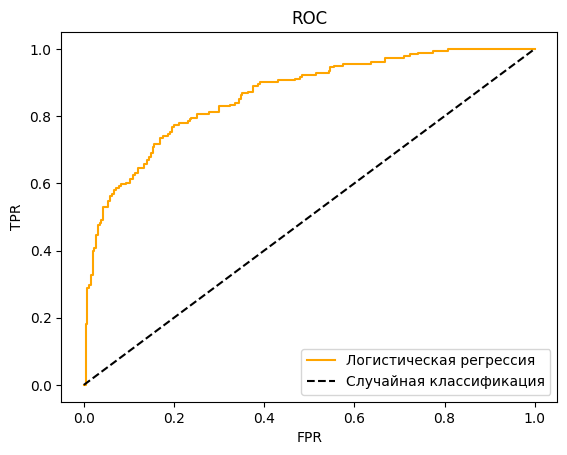

In [56]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:,1])
plt.plot(fpr, tpr, label="Логистическая регрессия", color="orange")
plt.plot([0, 1], [0, 1], color="black", linestyle='--', label="Случайная классификация")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()
plt.savefig('figures/ROC-curve.png')
plt.show()

В отличие от случайного классификатора, логистическая регрессия способна успешно распознать оба класса. ROC AUC увеличилась при использовании лог. регрессии с 0.5 (случайное угадывание) до 0.86. Accuracy возросла с 0.59 до 0.79.

В целом нет задачи, для которой случайное угаадывание было бы оправдывано, так как оно не способно дать осмысленного результата вприниципе. Даже если бы случайное угадывание показало качество равное модели машинного обучения, это бы больше говорило о том, что взаимосвязь между входом и выходом этой конкретной моделью обнаружить не удалось, и она тоже работала как случайный классификатор.

Сегодняшняя задача - не исключение. Логистическая регрессия показала высокую точность и является разумным выбором.
Если бы качество моделей совпало - значит, модель не научилась обобщать, следовательно непригодна для конкретной задачи.
Если же, по какой то причине, случайный классификатор работал бы лучше, то имело бы смысл инвертировать выходы логистической регрессии, что дало бы рабочую модель